# Homework 3


You will train a recurrent neural network that takes a code snippet and predicts which programming language it is written in. 

The dataset contains 11103 snippets for train and 2995 snippets for test from 6 programming languages: C++, C#, Python, JavaScript, HTML and SQL. Each programming language is almost equaly represented in the dataset.  The dataset is found in the course Google Drive folder lab03-tema03/\*-data-split, each snippets in a separate file and the labels are stored as dictionary in  lab03-tema03/code-\*-gt.json using filename as identifier. The dataset is a subset of the dataset used in [deep-learning-lang-detection](https://github.com/aliostad/deep-learning-lang-detection), that we cut in chunks of length 1000.

Your task is to investigate the best network architecture for this problem tuning RNN's hyperparameters (temperature, hidden_size) and  the maximum length of sequences used for training (you don't have to use the entire sequence of 1000 characters given in dataset).

For your models you have to report: \\
1.  Accuracy of the model on test set computed as: $\frac{\#correct\ predictions}{\#total\ predictions}$
2.   Confusion matrix: a matrix of $6 \times 6$ where $M_{i,j}$ is the number of examples from class $i$ classified by your model as $j$. How do you interpret these results?




 







In [1]:
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
from os import path
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam
from matplotlib import pyplot as plt
import glob
import unicodedata
import string


############################## CONSTANTS #######################################
def findFiles(path): return glob.glob(path)

ROOT_COLAB_FOLDER = "/content"
filename = "*.txt" #modify filename here
filepath = path.join(ROOT_COLAB_FOLDER, filename)

print(findFiles(filepath))

all_letters = string.ascii_letters + " .,;<>()[]!@#$%^&*-_=+~'0123456789/?\{}" + '"' + '\n'
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().split("+++___+++___+++___+++")
    return [unicodeToAscii(line.strip()) for line in lines]
  
for filename in findFiles(filepath):
    category = filename[len(ROOT_COLAB_FOLDER) + 1:filename.find('.txt')]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    for i in lines:
      if len(i) < 3:
        lines.remove(i)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/JavaScript.txt', '/content/c++.txt', '/content/Java.txt', '/content/Python.txt', '/content/c#.txt', '/content/SQL.txt']
Slusarski
JavaScript
c++
Java
Python
c#
SQL


In [2]:
print(category_lines['c++'][:5])
print(category_lines['SQL'][:5])
print(category_lines['JavaScript'][:5])


['namespace grace {\nFormattedStream& operator<<(FormattedStream& stream, const char *cstr) {\nstream.write((const byte*)cstr, strlen(cstr));\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, const String& str) {\nstream.write((const byte*)str.data(), str.size());\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, bool b) {\nstream << (b ? "true"  "false");\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, uint8 n) {\nstream << format("%u", n);\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, uint16 n) {\nstream << format("%u", n);\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, uint32 n) {\nstream << format("%u", n);\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, uint64 n) {\nstream << format("%llu", n);\nreturn stream;\n}\nFormattedStream& operator<<(FormattedStream& stream, char c) {\nstream.write((const byte*)&c, 1);\nreturn s', 'namespace E

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('7'))

print(lineToTensor('#include').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([8, 1, 93])


 **Arhitectura retelei**
 
 ![Arhitectura retelei](https://i.imgur.com/Z2xbySO.png)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 200
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('#include')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.8063, -1.7315, -1.8544, -1.8175, -1.7928, -1.7531]],
       grad_fn=<LogSoftmaxBackward>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('c++', 1)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line[:15] + "...")

category = SQL / line = display always
...
category = Python / line = controller_info...
category = Python / line = MIDI_CHANNEL = ...
category = JavaScript / line = var
kind = requ...
category = Python / line = b.save()
b = Bo...
category = c# / line = namespace JobPr...
category = Python / line = manage_addSchem...
category = c# / line = /*
    This cod...
category = c# / line = Size size;
    ...
category = c++ / line = /* -*- C++ -*- ...


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    output = None
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 1000
print_every = 10
plot_every = 10


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
#     print(category)
#     print(line)
#     print(len(line))
#     print(category_tensor)
#     print(line_tensor)
#     print("")
    if len(line) != 0:
      output, loss = train(category_tensor, line_tensor)
      current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line[:15], guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10 1% (0m 2s) 1.8399 #region
#endreg / Python ✗ (c#)
20 2% (0m 5s) 1.7595 prsg_excel.CELL / SQL ✓
30 3% (0m 7s) 1.8152 this.estateRepo / Python ✗ (Java)
40 4% (0m 10s) 1.7547 /**
 *   Dao Cl / Java ✓
50 5% (0m 12s) 1.7417 CREATE VIEW del / SQL ✓
60 6% (0m 15s) 1.7713 'underscore', ' / SQL ✗ (JavaScript)
70 7% (0m 17s) 1.8152 _handle_revisio / c# ✗ (Python)
80 8% (0m 20s) 1.7451 routes = [Endpo / c# ✗ (Python)
90 9% (0m 23s) 1.7910 return datetime / SQL ✗ (Python)
100 10% (0m 25s) 1.7533 internal set {  / c# ✓
110 11% (0m 28s) 1.8115 public class Wo / SQL ✗ (c#)
120 12% (0m 30s) 1.7971 inputtable->add / JavaScript ✗ (c++)
130 13% (0m 33s) 1.7664 --UPDATE oauth_ / Python ✗ (SQL)
140 14% (0m 35s) 1.7691 public class Pr / SQL ✗ (Java)
150 15% (0m 38s) 1.7053 .all()
    else / SQL ✗ (Python)
160 16% (0m 41s) 1.7555 invcitem_coitem / JavaScript ✗ (SQL)
170 17% (0m 43s) 1.7598 'use strict';
v / SQL ✗ (JavaScript)
180 18% (0m 46s) 1.8465 namespace NetPa / SQL ✗ (c#)
190 19% (0m 48s) 1.7249 INS

[1.8277311086654664, 1.7909117341041565, 1.7950580358505248, 1.778117823600769, 1.7958056211471558, 1.7984485745429992, 1.769394326210022, 1.7918856024742127, 1.7902866005897522, 1.7671833872795104, 1.796839213371277, 1.799327790737152, 1.805183720588684, 1.7983308672904967, 1.7915504932403565, 1.7813230752944946, 1.801123595237732, 1.8066445469856263, 1.788480019569397, 1.7960389733314515, 1.7929224133491517, 1.7928531169891357, 1.7810444235801697, 1.7777286052703858, 1.795383083820343, 1.7826627492904663, 1.788897454738617, 1.8016090154647828, 1.7905053496360779, 1.7866533994674683, 1.7960500955581664, 1.789870798587799, 1.7717394590377809, 1.8038982033729554, 1.7799579620361328, 1.7971812725067138, 1.7806668281555176, 1.7631237864494325, 1.779357135295868, 1.7673566460609436, 1.81150826215744, 1.793132758140564, 1.7926368713378906, 1.810204839706421, 1.7829415202140808, 1.796915054321289, 1.804424560070038, 1.804527962207794, 1.7800156354904175, 1.7692352056503295, 1.804203140735626

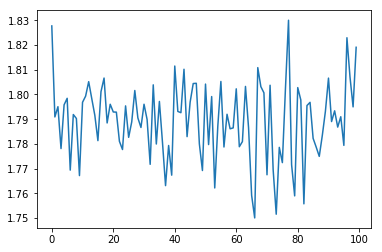

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


print(all_losses)

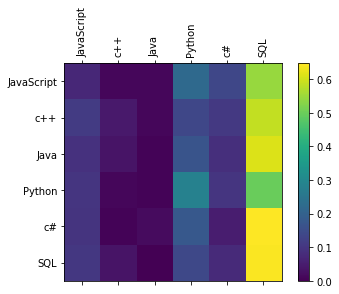

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    if len(line) != 0:
      output = evaluate(line_tensor)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('#include<bits/stdc++.h>')
predict('var i = GetComputedStyle(getElementById("button-red"))')
predict('SELECT * FROM EMPLOYEES')


> #include<bits/stdc++.h>
(-1.73) SQL
(-1.74) JavaScript
(-1.77) Python

> var i = GetComputedStyle(getElementById("button-red"))
(-1.74) Python
(-1.76) SQL
(-1.77) JavaScript

> SELECT * FROM EMPLOYEES
(-1.74) SQL
(-1.78) c++
(-1.79) c#
